# The Task at Hand

Have you ever wondered if computers could translate languages? Did you think google translate or duolingo worked because they memorized answers? 

The type of problem that translation solves is sequence to sequence. For instance, we could convert an english input sequence to a german output sequence. 

In this activity, we will create an english -> chinese translator and apply what we've been learning about LSTMs & RNNs.



## Preparing the data
We need to import our packages and data to learn a little bit about the problem at hand.

In [1]:
import numpy as np
import torch.nn as nn
from nltk.tokenize import WordPunctTokenizer
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import pandas as pd
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from Word2Sequence import Word2Sequence
from Dataset import Dataset
from Seq2Seq import Seq2Seq

In [2]:
# read small_en-cn.txt file
data_path = './eng-chin.txt'
df = pd.read_table(data_path,header=None).iloc[:,:]
df = df.drop([2],axis=1)
df.columns=['english','chinese']

input_texts = df.english.values.tolist() #this will be all of the english sentences
target_texts = df.chinese.values.tolist() #this will be all of the chinese sentences

In [8]:
'''
Your code here: Try printing some english and chinese sentences from their lists input_texts and target_texts!
'''
print(input_texts)
print(target_texts)

['Does any other country fan the flames of patriotism as much as America?', 'I always enjoy listening to classical music when I have some free time.', 'I was nine years old when I asked my mom if Santa Claus really existed.', "I'm a foreigner and I don't know Czech very well. Please, speak slowly.", "If it's at all possible, I'd like you to take part in the next meeting.", 'If you enjoy the work you do, you have something worth more than money.', "It was not until I had a baby myself that I knew what mother's love is.", 'Kindness is the language which the deaf can hear and the blind can see.', 'Mary came home from school in tears because her friends had teased her.', 'My father was no less affectionate and tender to me than my mother was.', "Now's the time to decide whether you really want to get married or not.", 'People show up bright on an infrared camera because of their body heat.', 'The police have been searching for the stolen goods for almost a month.', 'They told me that I wou

In [10]:
#read in our model object. Tokenize our data
tk = WordPunctTokenizer()
english = [tk.tokenize(sentence.lower()) for sentence in input_texts]
chinese = [[x for x in sentence] for sentence in target_texts]

print(english)

[['does', 'any', 'other', 'country', 'fan', 'the', 'flames', 'of', 'patriotism', 'as', 'much', 'as', 'america', '?'], ['i', 'always', 'enjoy', 'listening', 'to', 'classical', 'music', 'when', 'i', 'have', 'some', 'free', 'time', '.'], ['i', 'was', 'nine', 'years', 'old', 'when', 'i', 'asked', 'my', 'mom', 'if', 'santa', 'claus', 'really', 'existed', '.'], ['i', "'", 'm', 'a', 'foreigner', 'and', 'i', 'don', "'", 't', 'know', 'czech', 'very', 'well', '.', 'please', ',', 'speak', 'slowly', '.'], ['if', 'it', "'", 's', 'at', 'all', 'possible', ',', 'i', "'", 'd', 'like', 'you', 'to', 'take', 'part', 'in', 'the', 'next', 'meeting', '.'], ['if', 'you', 'enjoy', 'the', 'work', 'you', 'do', ',', 'you', 'have', 'something', 'worth', 'more', 'than', 'money', '.'], ['it', 'was', 'not', 'until', 'i', 'had', 'a', 'baby', 'myself', 'that', 'i', 'knew', 'what', 'mother', "'", 's', 'love', 'is', '.'], ['kindness', 'is', 'the', 'language', 'which', 'the', 'deaf', 'can', 'hear', 'and', 'the', 'blind', 

In [37]:
'''
Your code here: Explore this data. Can you calculate the maximum length of a sequence in each dataset english and chinese?
'''
# calculate max_len of any sequence in 'english' list and save it to a variable called max_english_length

max_english_length = 0

for sentence in english:
    maxlenold = len(sentence)
    if maxlenold > max_english_length:
        max_english_length = maxlenold
    #print(maxlen)
print(max_english_length)


# calculate max_len of any sequence in 'chinese' list and save it to a variable called max_chinese_length

max_chinese_length = 0

for sentence in chinese:
    maxlcnold = len(sentence)
    if maxlcnold > max_chinese_length:
        max_chinese_length = maxlcnold
    #print(maxlen)
print(max_chinese_length)

25
39


In [32]:
input_tokenizer = Word2Sequence()
for words in english:
    input_tokenizer.fit(words)
input_tokenizer.build_vocab(min=1, max_features=None) #input

output_tokenizer = Word2Sequence()
for words in chinese:
    output_tokenizer.fit(words)
output_tokenizer.build_vocab(min=1, max_features=None)

'''
Your code here: print the total english words in your input tokenizer and total chinese words in your output tokenizer below!
'''
print(input_tokenizer.__len__())

print(output_tokenizer.__len__())


199
317


<h1>Creating the model</h1>

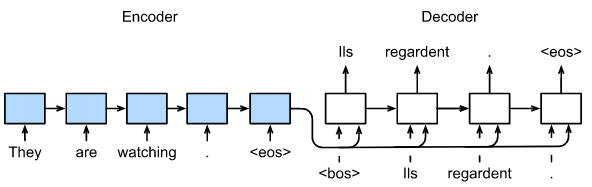

NOTE: For Structure of Encoder Inputs, they can all be either (assume all have same maxlen): 

1. \<SOS>, word1, word2, word3, ..., \<EOS>
2. word1, word2, word3, ..., \<EOS> 
3. word1, word2, word3, ...

NOTE: But Decoder In and Out structures should always look like this (assume all have same maxlen):

- Decoder Input: \<SOS>, word1, word2, word3, ...
- Decoder Output: word1, word2, word3, ..., \<EOS>  

This means that our input and ouput max length should be one more than the sequence's max length.

WHY? Data Structure:

- 1. Encoder Input: [word1, word2, ... + <EOS>]
- 2. Decoder Input: [<SOS> + word1, word2, ...]
- 3. Decoder Output:[word1, word2, ... + <EOS>]
    

nn docs - https://pytorch.org/docs/stable/nn.html



In [39]:
# Seq2Seq Parameters
in_maxlen = max_english_length + 1 # 25 + 1(<EOS> token)
out_maxlen = max_chinese_length + 1 # 39 + 1(<EOS> token or <SOS> token)
n_hidden = 32 # number of "neurons" per layer
d_model = 64 # number of embedding dimensions to represent each word
enc_n_class = len(input_tokenizer.dict) # OR... vocab size of englisth -> 199
dec_n_class = len(output_tokenizer.dict) # OR... vocab size of chinese -> 317
batch_size = 1

In [38]:
eng_maxlen = max_english_length + 1 # 25 + 1(<EOS> token)
chin_maxlen = max_chinese_length + 1  # 39 + 1(<EOS> token or <SOS> token)
batch_size = 1

# Setup the Dataset.
dataset = Dataset(
    X = english,
    Y = chinese,
    in_tknz = input_tokenizer, out_tknz = output_tokenizer,
    in_maxlen = eng_maxlen, out_maxlen = chin_maxlen
)

'''
The following are helper functions to help pytorch. You won't need to know this much.
'''
# NOTE: collate_fn preprocesses your input from PyTorch Dataset above during PyTorch DataLoader
def collate_fn(batch):
    '''
    param batch: ([enc_in, dec_in, dec_out]， [enc_in, dec_in, dec_out], output of getitem...)
    '''
    # unpack values
    enc_in, dec_in, dec_out = list(zip(*batch))
    # Return tensor type
    return torch.LongTensor(enc_in), torch.LongTensor(dec_in), torch.LongTensor(dec_out)

def get_dataloader(dataset, batch_size, shuffle=True, drop_last=True, collate_fn=collate_fn):
    '''
    Returns a way to access and use the data
    '''
    dataloader = DataLoader(dataset=dataset,
                            batch_size=batch_size,
                            shuffle=shuffle,
                            drop_last=drop_last,
                            collate_fn=collate_fn)
    return dataloader
# Get PyTorch DataLoader
dataloader = get_dataloader(dataset, batch_size)
dataloader = get_dataloader(dataset, batch_size)

In [59]:
model = Seq2Seq(
    in_maxlen = in_maxlen,
    out_maxlen = out_maxlen,
    n_hidden = n_hidden,
    enc_n_class = len(input_tokenizer.dict),
    dec_n_class = len(output_tokenizer.dict),
    d_model = d_model,
    num_layers = 1,
)
model.to(device)
# # If you have saved a model before
# model.load_state_dict(torch.load("seq2seq.pt", map_location=device))

Seq2Seq(
  (encoder): GRU(64, 32, dropout=0.3)
  (decoder): GRU(64, 32, dropout=0.3)
  (embed_enc): Embedding(199, 64)
  (embed_dec): Embedding(317, 64)
  (fc): Linear(in_features=32, out_features=317, bias=True)
)

In [60]:
# Define Loss and Optimizer -- these are ways we define performance for our model. If you're curious: https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=1e-2)

<h1>tRaInInG oUr MoDeL</h1>



In [61]:
'''
Your code here: change the number of epochs to see how it effects training time and quality
'''
epochs = 200


'''
Training -- no need to touch the code below.
'''
torch.cuda.empty_cache()
model.train()
model.to(device)
loss_records = []


for epoch in range(epochs):
    # runs the model and calculates loss
    loss = 0
    for _, (enc_in, dec_in, dec_out) in enumerate(dataloader):
        # enc_h_0.shape: [1(num_layers), 1(batch_size), 32(hidden_size)]
        enc_h_0 = model.init_enc_hidden_GRU(batch_size, device)
        # To Cuda Device if available
        enc_in, dec_in = enc_in.to(device), dec_in.to(device)

        pred = model(enc_in, enc_h_0, dec_in)

        dec_out = dec_out.to(device)
        for i in range(len(dec_out)): # dec_in.shape: [1(b), 40(out_maxlen)]
            # pred[i].shape: [40(out_maxlen), 317(dec_n_class)]
            # dec_out[i].shape: [40(out_maxlen)]
            loss += criterion(pred[i], dec_out[i])

    if (epoch) % 1 == 0:
        print(f"Epoch: {epoch}, Loss: {loss}")

    if (epoch) % 100 == 0:
        loss_records.append(loss)

    # runs the actual back propacation
    optim.zero_grad()
    loss.backward()
    optim.step()
    torch.save(model.state_dict(), "seq2seq.pt")

Epoch: 0, Loss: 575.5717163085938


Epoch: 1, Loss: 519.2578125


Epoch: 2, Loss: 475.4347839355469


Epoch: 3, Loss: 442.1078796386719


Epoch: 4, Loss: 413.8287048339844


Epoch: 5, Loss: 386.9122619628906


Epoch: 6, Loss: 360.6662292480469


Epoch: 7, Loss: 336.0145263671875


Epoch: 8, Loss: 314.1577453613281


Epoch: 9, Loss: 295.8831481933594


Epoch: 10, Loss: 281.384765625


Epoch: 11, Loss: 270.3678894042969


Epoch: 12, Loss: 262.24462890625


Epoch: 13, Loss: 256.3305969238281


Epoch: 14, Loss: 251.9749298095703


Epoch: 15, Loss: 248.62973022460938


Epoch: 16, Loss: 245.85562133789062


Epoch: 17, Loss: 243.30599975585938


Epoch: 18, Loss: 240.78565979003906


Epoch: 19, Loss: 238.3236083984375


Epoch: 20, Loss: 236.02650451660156


Epoch: 21, Loss: 233.90499877929688


Epoch: 22, Loss: 231.9191131591797


Epoch: 23, Loss: 229.98716735839844


Epoch: 24, Loss: 228.03741455078125


Epoch: 25, Loss: 226.041015625


Epoch: 26, Loss: 223.97512817382812


Epoch: 27, Loss: 221.85195922851562


Epoch: 28, Loss: 219.71035766601562


Epoch: 29, Loss: 217.58596801757812


Epoch: 30, Loss: 215.4944610595703


Epoch: 31, Loss: 213.42852783203125


Epoch: 32, Loss: 211.36378479003906


Epoch: 33, Loss: 209.27037048339844


Epoch: 34, Loss: 207.1254425048828


Epoch: 35, Loss: 204.92007446289062


Epoch: 36, Loss: 202.6622314453125


Epoch: 37, Loss: 200.36959838867188


Epoch: 38, Loss: 198.0574188232422


Epoch: 39, Loss: 195.74119567871094


Epoch: 40, Loss: 193.4237060546875


Epoch: 41, Loss: 191.09950256347656


Epoch: 42, Loss: 188.76351928710938


Epoch: 43, Loss: 186.4110870361328


Epoch: 44, Loss: 184.03759765625


Epoch: 45, Loss: 181.64393615722656


Epoch: 46, Loss: 179.23336791992188


Epoch: 47, Loss: 176.8151092529297


Epoch: 48, Loss: 174.39688110351562


Epoch: 49, Loss: 171.9832763671875


Epoch: 50, Loss: 169.5782012939453


Epoch: 51, Loss: 167.19041442871094


Epoch: 52, Loss: 164.81285095214844


Epoch: 53, Loss: 162.4415740966797


Epoch: 54, Loss: 160.08251953125


Epoch: 55, Loss: 157.74403381347656


Epoch: 56, Loss: 155.42868041992188


Epoch: 57, Loss: 153.12832641601562


Epoch: 58, Loss: 150.83935546875


Epoch: 59, Loss: 148.569091796875


Epoch: 60, Loss: 146.3199462890625


Epoch: 61, Loss: 144.08641052246094


Epoch: 62, Loss: 141.86972045898438


Epoch: 63, Loss: 139.67709350585938


Epoch: 64, Loss: 137.50840759277344


Epoch: 65, Loss: 135.35995483398438


Epoch: 66, Loss: 133.23233032226562


Epoch: 67, Loss: 131.13307189941406


Epoch: 68, Loss: 129.06370544433594


Epoch: 69, Loss: 127.01480865478516


Epoch: 70, Loss: 124.98944854736328


Epoch: 71, Loss: 122.98826599121094


Epoch: 72, Loss: 121.00604248046875


Epoch: 73, Loss: 119.0541763305664


Epoch: 74, Loss: 117.13282775878906


Epoch: 75, Loss: 115.23896026611328


Epoch: 76, Loss: 113.37016296386719


Epoch: 77, Loss: 111.5250473022461


Epoch: 78, Loss: 109.70712280273438


Epoch: 79, Loss: 107.91398620605469


Epoch: 80, Loss: 106.1516342163086


Epoch: 81, Loss: 104.4078369140625


Epoch: 82, Loss: 102.68170166015625


Epoch: 83, Loss: 100.97583770751953


Epoch: 84, Loss: 99.29212188720703


Epoch: 85, Loss: 97.62538146972656


Epoch: 86, Loss: 95.98739624023438


Epoch: 87, Loss: 94.38090515136719


Epoch: 88, Loss: 92.78578186035156


Epoch: 89, Loss: 91.21329498291016


Epoch: 90, Loss: 89.6609878540039


Epoch: 91, Loss: 88.12102508544922


Epoch: 92, Loss: 86.60914611816406


Epoch: 93, Loss: 85.117431640625


Epoch: 94, Loss: 83.66741943359375


Epoch: 95, Loss: 82.22160339355469


Epoch: 96, Loss: 80.80804443359375


Epoch: 97, Loss: 79.39954376220703


Epoch: 98, Loss: 78.0044937133789


Epoch: 99, Loss: 76.65457153320312


Epoch: 100, Loss: 75.30638122558594


Epoch: 101, Loss: 73.95574188232422


Epoch: 102, Loss: 72.65831756591797


Epoch: 103, Loss: 71.38794708251953


Epoch: 104, Loss: 70.08033752441406


Epoch: 105, Loss: 68.90855407714844


Epoch: 106, Loss: 67.67762756347656


Epoch: 107, Loss: 66.46713256835938


Epoch: 108, Loss: 65.26444244384766


Epoch: 109, Loss: 64.04718780517578


Epoch: 110, Loss: 62.92475891113281


Epoch: 111, Loss: 61.75179672241211


Epoch: 112, Loss: 60.67043685913086


Epoch: 113, Loss: 59.518714904785156


Epoch: 114, Loss: 58.4494514465332


Epoch: 115, Loss: 57.35446548461914


Epoch: 116, Loss: 56.28012466430664


Epoch: 117, Loss: 55.255855560302734


Epoch: 118, Loss: 54.22874069213867


Epoch: 119, Loss: 53.23716354370117


Epoch: 120, Loss: 52.27701187133789


Epoch: 121, Loss: 51.30961990356445


Epoch: 122, Loss: 50.40264892578125


Epoch: 123, Loss: 49.49873352050781


Epoch: 124, Loss: 48.63178253173828


Epoch: 125, Loss: 47.72373580932617


Epoch: 126, Loss: 46.843109130859375


Epoch: 127, Loss: 45.97144317626953


Epoch: 128, Loss: 45.1539421081543


Epoch: 129, Loss: 44.35331344604492


Epoch: 130, Loss: 43.58383560180664


Epoch: 131, Loss: 42.8590202331543


Epoch: 132, Loss: 42.092803955078125


Epoch: 133, Loss: 41.355133056640625


Epoch: 134, Loss: 40.529544830322266


Epoch: 135, Loss: 39.882301330566406


Epoch: 136, Loss: 39.32588577270508


Epoch: 137, Loss: 38.49338912963867


Epoch: 138, Loss: 37.97258377075195


Epoch: 139, Loss: 37.46438217163086


Epoch: 140, Loss: 36.63025665283203


Epoch: 141, Loss: 36.169376373291016


Epoch: 142, Loss: 35.33946990966797


Epoch: 143, Loss: 34.800323486328125


Epoch: 144, Loss: 34.21947479248047


Epoch: 145, Loss: 33.54607391357422


Epoch: 146, Loss: 33.04350662231445


Epoch: 147, Loss: 32.43174362182617


Epoch: 148, Loss: 31.868898391723633


Epoch: 149, Loss: 31.360275268554688


Epoch: 150, Loss: 30.764545440673828


Epoch: 151, Loss: 30.2314453125


Epoch: 152, Loss: 29.746034622192383


Epoch: 153, Loss: 29.242359161376953


Epoch: 154, Loss: 28.796772003173828


Epoch: 155, Loss: 28.27716636657715


Epoch: 156, Loss: 27.772560119628906


Epoch: 157, Loss: 27.322795867919922


Epoch: 158, Loss: 26.86190414428711


Epoch: 159, Loss: 26.423276901245117


Epoch: 160, Loss: 26.01631736755371


Epoch: 161, Loss: 25.579036712646484


Epoch: 162, Loss: 25.199562072753906


Epoch: 163, Loss: 24.76216697692871


Epoch: 164, Loss: 24.34266471862793


Epoch: 165, Loss: 23.930381774902344


Epoch: 166, Loss: 23.517879486083984


Epoch: 167, Loss: 23.176435470581055


Epoch: 168, Loss: 22.885295867919922


Epoch: 169, Loss: 22.472396850585938


Epoch: 170, Loss: 22.142189025878906


Epoch: 171, Loss: 21.720428466796875


Epoch: 172, Loss: 21.399690628051758


Epoch: 173, Loss: 21.01036262512207


Epoch: 174, Loss: 20.666728973388672


Epoch: 175, Loss: 20.333751678466797


Epoch: 176, Loss: 19.988359451293945


Epoch: 177, Loss: 19.66593360900879


Epoch: 178, Loss: 19.340412139892578


Epoch: 179, Loss: 19.047216415405273


Epoch: 180, Loss: 18.695159912109375


Epoch: 181, Loss: 18.41575813293457


Epoch: 182, Loss: 18.118677139282227


Epoch: 183, Loss: 17.830854415893555


Epoch: 184, Loss: 17.532176971435547


Epoch: 185, Loss: 17.279577255249023


Epoch: 186, Loss: 17.042404174804688


Epoch: 187, Loss: 16.785860061645508


Epoch: 188, Loss: 16.50421714782715


Epoch: 189, Loss: 16.300846099853516


Epoch: 190, Loss: 16.07366943359375


Epoch: 191, Loss: 15.922374725341797


Epoch: 192, Loss: 15.77094841003418


Epoch: 193, Loss: 15.44147777557373


Epoch: 194, Loss: 15.214373588562012


Epoch: 195, Loss: 14.977567672729492


Epoch: 196, Loss: 14.754707336425781


Epoch: 197, Loss: 14.518855094909668


Epoch: 198, Loss: 14.3389892578125


Epoch: 199, Loss: 14.132500648498535


## Let's check out our model's progress

No need to change the code below, this will plot our loss over time. How do you think we can tweak our code to decrease loss even further?



In [45]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
%matplotlib inline
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points): # Helper function for showing our plots
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

<Figure size 432x288 with 0 Axes>

Locator attempting to generate 2753 ticks ([50.2, ..., 600.6]), which exceeds Locator.MAXTICKS (1000).


Locator attempting to generate 2753 ticks ([50.2, ..., 600.6]), which exceeds Locator.MAXTICKS (1000).


Locator attempting to generate 2753 ticks ([50.2, ..., 600.6]), which exceeds Locator.MAXTICKS (1000).


Locator attempting to generate 2753 ticks ([50.2, ..., 600.6]), which exceeds Locator.MAXTICKS (1000).


Locator attempting to generate 2753 ticks ([50.2, ..., 600.6]), which exceeds Locator.MAXTICKS (1000).


Locator attempting to generate 2753 ticks ([50.2, ..., 600.6]), which exceeds Locator.MAXTICKS (1000).


Locator attempting to generate 2753 ticks ([50.2, ..., 600.6]), which exceeds Locator.MAXTICKS (1000).


Locator attempting to generate 2753 ticks ([50.2, ..., 600.6]), which exceeds Locator.MAXTICKS (1000).


Locator attempting to generate 2753 ticks ([50.2, ..., 600.6]), which exceeds Locator.MAXTICKS (1000).


Locator attempting to generate 2753 ticks ([50.2, ..., 600.6]), which exceeds Locator.MAXTICKS (1000).


Locator attempting to generate 2753 ticks ([50.2, ..., 600.6]), which exceeds Locator.MAXTICKS (1000).


Locator attempting to generate 2753 ticks ([50.2, ..., 600.6]), which exceeds Locator.MAXTICKS (1000).


Locator attempting to generate 2753 ticks ([50.2, ..., 600.6]), which exceeds Locator.MAXTICKS (1000).


Locator attempting to generate 2753 ticks ([50.2, ..., 600.6]), which exceeds Locator.MAXTICKS (1000).


Locator attempting to generate 2753 ticks ([50.2, ..., 600.6]), which exceeds Locator.MAXTICKS (1000).


Locator attempting to generate 2753 ticks ([50.2, ..., 600.6]), which exceeds Locator.MAXTICKS (1000).


Locator attempting to generate 2753 ticks ([50.2, ..., 600.6]), which exceeds Locator.MAXTICKS (1000).


Locator attempting to generate 2753 ticks ([50.2, ..., 600.6]), which exceeds Locator.MAXTICKS (1000).


Locator attempting to generate 2753 ticks ([50.2, ..., 600.6]), which exceeds Locator.MAXTICKS (1000).


Locator attempting to generate 2753 ticks ([50.2, ..., 600.6]), which exceeds Locator.MAXTICKS (1000).


Locator attempting to generate 2753 ticks ([50.2, ..., 600.6]), which exceeds Locator.MAXTICKS (1000).


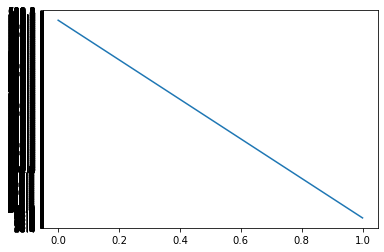

In [62]:
showPlot([loss.cpu().item() for loss in loss_records])

<h1>Code for Translating with our Model</h1>
This is where the Seq2Seq happens after the model is trained.


In [63]:
'''
No need to touch this code: 
'''

def translate(eng_sent, model, device):
    # set up the inputs and variables
    model.eval()
    model.to(device)
    eng_sent = tk.tokenize(eng_sent.lower()) + ["<EOS>"]
    eng_sent = input_tokenizer.transform(eng_sent, max_len=in_maxlen, pad_first=False)
    dec_in = (["<SOS>"] + ["<PAD>"]*out_maxlen)[:out_maxlen]
    dec_in = output_tokenizer.transform(dec_in, max_len=out_maxlen, pad_first=False)

    enc_h_0 = model.init_enc_hidden_GRU(batch_size, device)
    eng_sent, dec_in = torch.LongTensor(eng_sent), torch.LongTensor(dec_in)

    eng_sent = eng_sent.unsqueeze(0)
    dec_in = dec_in.unsqueeze(0)
    eng_sent, dec_in = eng_sent.to(device), dec_in.to(device)

    # run the model
    with torch.no_grad():
        # eng_sent: [1(b), 26(in_maxlen)]
        embedded_X = model.embed_enc(eng_sent)
        # embedded_X: [26(in_maxlen), 1(b), 64(d_model)] <- [1(b), 26(in_maxlen), 64(d_model)]
        embedded_X = embedded_X.permute(1, 0, 2)
        _, memory = model.encoder(embedded_X, enc_h_0)
        pred_loc = 0
        for i in range(out_maxlen-1):
            embedded_Y = model.embed_dec(dec_in)
            embedded_Y = embedded_Y.permute(1, 0, 2)
            outputs, _ = model.decoder(embedded_Y, memory)
            outputs = outputs.permute(1, 0, 2)
            pred = model.fc(outputs)
            pred = pred[0][pred_loc].topk(1)[1].item()
            pred_loc += 1
            if pred == 2:
                dec_in[0][pred_loc] = pred
                break
            else:
                dec_in[0][pred_loc] = pred
    return dec_in

# Using our Model in Practice
Check out these examples below. This is how you can translate sequences!

In [64]:
import random
eng_sents = random.sample(input_texts, 5)
for sent in eng_sents:
  translated = translate(sent, model, torch.device("cpu"))
  translated_sent = output_tokenizer.inverse_transform(translated[0], is_tensor=True)
  translated_sent = "".join([word for word in translated_sent if word != "<SOS>" and word != "<EOS>"and word != "<PAD>"])
  print(f"{sent} -> \n{translated_sent}")

Now's the time to decide whether you really want to get married or not. -> 
现在是你<UNK>定是不是真要结婚的时候。
To the man who only has a hammer in the toolkit, every problem looks like a nail. -> 
对工<UNK>箱里只有一把<UNK><UNK>的人来说，所有的问<UNK>都像<UNK>子。
The good thing about this electronic dictionary is that it's easy to carry. -> 
这电子<UNK>典的好处就是便于<UNK><UNK>。
Manholes are round because that way they won't accidentally fall through the hole. -> 
人孔是<UNK>的，因為這<UNK>人孔<UNK>就不會意外地<UNK><UNK><UNK><UNK>。


Whoever said money can't buy happiness simply didn't know where to go shopping. -> 
那些说钱不能买来幸福的人，只是不知道上哪里去买而已。


# Your turn!

Can you use the code in the cell above to translate custom sentences? 



In [1]:
'''
Your code here: translate custom sentences using the code above. Hint: You won't need a for loop!
'''

engeng_sents = input("Ok. You dont know chinese? fine... here:")
translated = translate(engeng_sents, model, torch.device("cpu"))
translated_sent = output_tokenizer.inverse_transform(translated[0], is_tensor=True)
translated_sent = "".join([word for word in translated_sent if word != "<SOS>" and word != "<EOS>"and word !="<PAD>"])
print(translated_sent)


Ok. You dont know chinese? fine... here: 